In [33]:
import tensorflow as tf
import numpy as np
import tf_agents

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
import matplotlib.animation as animation


from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import py_tf_eager_policy
from tf_agents.drivers import py_driver
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver

from scipy.spatial.transform import Rotation as rotate
from scipy.spatial import distance
import math


In [34]:
class UR_env(py_environment.PyEnvironment):    
    _ur3_params=np.array([[0,0,151.9],[-243.65,0,0],[-213.25,0,0],[0,0, 112.35],[0,0,85.35],[0,0,81.9]],dtype=np.float32)
    _joint_rotation=np.array([[0,0,0],[0,90,0],[0,0,0],[0,0,0],[0,90,0],[0,-90,0]],dtype=np.float32)    
    _home_position = np.array([180,-90,0,0,0,0],dtype=np.float32)
    _defoult_target = np.array([250,-100,100,0,180,0],dtype=np.float32)        

    def __init__( self, 
        max_steps=20, 
        discount=0.99, 
        joints_angles =_home_position, 
        target = _defoult_target,
        max_anglular_velocity=5,
        duration_step=1,
        stop_acuracy=25,
        obs_min=(-360,-360,-360,-360,-360,-360),
        obs_max=(360,360,360,360,360,360)):
       
        self._action_spec = array_spec.BoundedArraySpec(
        shape=(6,), dtype=np.float32, minimum=[-1,-1,-1,-1,-1,-1], maximum=[1,1,1,1,1,1], name='action')        
        self._observation_spec = array_spec.BoundedArraySpec(
        shape=(6,), dtype=np.float32, minimum=obs_min, maximum=obs_max, name='observation')       
        self._discount_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.float32, minimum=0., maximum=1, name='discount')
        self._reward_spec = array_spec.ArraySpec(shape=(), dtype=np.float32, name='reward')

        self._episode_ended = False

        self.obs_min=obs_min
        self.obs_max=obs_max
        self.max_anglular_velocity=max_anglular_velocity
        self.duration_step=duration_step
        self.stop_acuracy=stop_acuracy
        self.step_counter:int=0
        self.max_steps=max_steps
        self.discount = discount

        self._joints_angles=np.copy(joints_angles)
        self._joints_positions = []    
        self._begin_position =self.__forward_kinematic_ur3(self._joints_angles)
        self._state = np.copy(self._begin_position)
        self._target = np.copy(target)

        self._target_angles = self.__find_angles(target[3:])   
        self._previous_angles = self.__find_angles(self._state[3:])   
        self._previous_quotient_of_angles = self.__compute_angle_quotient(self._previous_angles)
        self._defoult_angle_quotient= self.__compute_angle_quotient(self._previous_angles)         
        
        self._all_distance= distance.euclidean(self._begin_position[:3],self._target[:3])
        self._previous_distance=distance.euclidean(self._begin_position[:3],self._target[:3])
        
        self._angle_quotient_buffer_episode=[self._defoult_angle_quotient]
        self.trajectory = [self._state[:3]]
        self._distance_buffer_episode = [self._all_distance]
    def get_joints_positions(self): return self._joints_positions
    def get_joints_angles(self): return self._joints_angles
    def get_trajectory(self): return self.trajectory
    def get_distance_episode(self): return self._distance_buffer_episode
    def get_angle_quotient_episode(self): return self._angle_quotient_buffer_episode
    
    def action_spec(self):        return self._action_spec
    def observation_spec(self):        return self._observation_spec    
    def discount_spec(self):        return self._discount_spec
    def reward_spec(self):        return self._reward_spec

    def _reset(self):
        self.step_counter=0
        self._state = np.copy(self._begin_position)
        self._joints_angles=np.copy(self._home_position)
        self._episode_ended = False
        self._previous_distance = self._all_distance
        self._previous_quotient_of_angles=self._defoult_angle_quotient
        self.trajectory = [self._state[:3]]
        self._distance_buffer_episode = [self._all_distance]
        self._angle_quotient_buffer_episode=[self._defoult_angle_quotient]
        return ts.restart(self._joints_angles)

    def __forward_kinematic_ur3(self,parameters):
        position:np.float64=[0,0,0]
        orientation=rotate.from_euler('ZXZ',[0,0,0],degrees=True)
        base_angle=np.copy(self._joint_rotation)
        for index, param in enumerate(parameters):
            base_angle[index][2]+=param
            new_rotation=rotate.from_euler('ZXZ',base_angle[index],degrees=True)
            orientation:rotate=orientation*new_rotation
            rot_pos=orientation.apply(self._ur3_params[index])
            position+=rot_pos
            j_pos = position.copy()
            j_orient =orientation.as_euler('ZXZ',degrees=True)
            self._joints_positions.append(np.array([j_pos,j_orient],dtype=np.float32))
        orientation=np.array(orientation.as_euler('ZXZ',degrees=True),dtype=np.float32)
        comlex = np.concatenate((position, orientation), dtype=np.float32, axis=None)
        return comlex
    
    def __find_reward(self):        
        discount=math.pow(self.discount,1+self.step_counter) 
        this_distance=distance.euclidean(self._target[:3],self._state[:3])
        this_angles = self.__find_angles(self._state[3:])
        this_quotient_of_angles = self.__compute_angle_quotient(this_angles)

        self._distance_buffer_episode.append(this_distance)
        self._angle_quotient_buffer_episode.append(this_quotient_of_angles)

        line_difference = self._previous_distance-this_distance
        reward_1=line_difference/self._all_distance

        angle_difference=self._previous_quotient_of_angles- this_quotient_of_angles
        reward_2=angle_difference/self._defoult_angle_quotient

        # reward_2=0

        # if reward_1<0: reward_1*=2
        # if reward_2<0: reward_2*=2

        self._previous_distance=this_distance
        self._previous_quotient_of_angles=this_quotient_of_angles

        reward=(reward_1+reward_2)*discount*1000
        return reward

    def __find_angles(self, angles_ZXZ):
        rot_matrix=rotate.from_euler('ZXZ',angles_ZXZ,degrees=True)
        axis_x=rot_matrix.apply([1,0,0])
        axis_y=rot_matrix.apply([0,1,0])
        axis_z=rot_matrix.apply([0,0,1])
        
        dist = distance.cosine([1,0,0],axis_x)
        angle_x=np.rad2deg(np.arccos(1 - dist))

        dist = distance.cosine([0,1,0],axis_y)
        angle_y=np.rad2deg(np.arccos(1 - dist))

        dist = distance.cosine([0,0,1],axis_z)
        angle_z=np.rad2deg(np.arccos(1 - dist))

        return [angle_x,angle_y,angle_z]    
    
    def __compute_angle_quotient(self, angle):
        def_angle=self._target[:3]
        return math.sqrt(
            pow(def_angle[0]-angle[0],2)+
            pow(def_angle[1]-angle[1],2)+
            pow(def_angle[2]-angle[2],2)
            )

    def _step(self, action):       
        if self._episode_ended:
            return self.reset()        
        self.step_counter+=1
        self._joints_positions=[]
        angle_limitations_reward = 0
        for index, act in enumerate(action):
            angle=(self.max_anglular_velocity*act)*self.duration_step
            self._joints_angles[index]+=angle                
            if (self._joints_angles[index]>360):
                self._joints_angles[index]=(self._joints_angles[index]-360)*-1
            elif (self._joints_angles[index]<-360):
                self._joints_angles[index]=(self._joints_angles[index]+360)*-1
        self._state = self.__forward_kinematic_ur3(self._joints_angles)
        reward=self.__find_reward()   
        self.trajectory.append(self._state[:3])
        
        if self._previous_distance < self.stop_acuracy or self.step_counter>self.max_steps:
            self._episode_ended=True
            if self._previous_distance < self.stop_acuracy: reward+=1

        if self._episode_ended==True:
            return ts.termination(observation = self._joints_angles, reward = reward)
        return ts.transition(observation = self._joints_angles, reward = reward, discount = self.discount)
    
    def _convert_to_array (self, fig):
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return data
    
    def render(self):
        target=self._target[:3]
        fig = plt.figure()
        frame = fig.add_subplot(111,projection="3d")
        frame.set_xlim3d(-500, 500)
        frame.set_ylim3d(-500, 500)
        frame.set_zlim3d(0, 1000)
        target = frame.plot(
            target[0],
            target[1],
            target[2],
            '-ro',
            label='target')
        colors = ('r','g','b','y','c','m','k')
        iterator = iter(colors)   

        if self.step_counter!=1:
            for i in range(len(self.trajectory)-1):
                x=[self.trajectory[i][0],self.trajectory[i+1][0]]
                y=[self.trajectory[i][1],self.trajectory[i+1][1]]
                z=[self.trajectory[i][2],self.trajectory[i+1][2]]
                trajectory = frame.plot(x,y,z,color='k')  
        link = []
        for index in range(len(self._joints_positions[:-1])):          
            color = next(iterator)
            x=[self._joints_positions[index][0][0],self._joints_positions[index+1][0][0]]
            y=[self._joints_positions[index][0][1],self._joints_positions[index+1][0][1]]
            z=[self._joints_positions[index][0][2],self._joints_positions[index+1][0][2]]
            link.append(frame.plot(x,y,z,color=color))
        x = [self._joints_positions[0][0][0],0]
        y = [self._joints_positions[0][0][1],0]
        z = [self._joints_positions[0][0][2],0]
        base = frame.plot(x,y,z,color='m')
        return self._convert_to_array(fig)

In [35]:
test_env = UR_env()
utils.validate_py_environment(test_env,episodes=5,)
print('ok')

ok


C:\Users\Антон\AppData\Local\Temp\ipykernel_10736\1404663428.py:88: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  j_orient =orientation.as_euler('ZXZ',degrees=True)


In [36]:
number_iterations = 20000
max_anglular_velocity = 10
max_steps_env=18
discount = 1
fc_layer_params=(300,300)
learning_rate = 0.000001
number_eval_episodes = 1
collect_steps = max_steps_env+1
eval_interval = 200
# 0.9   0.000001

In [37]:
# obs_min=(0,0,0,0,0,0),
# obs_max=(360,360,360,360,360,360):
       
obs_min=(-360)
obs_max=(360)
target = np.array([400, -100, 100, 0, -180, 0],dtype=np.float32)
train_env_py= UR_env(max_steps=max_steps_env, max_anglular_velocity=max_anglular_velocity, target=target,obs_max=obs_max,obs_min=obs_min)
train_env_tf=tf_py_environment.TFPyEnvironment(train_env_py)

C:\Users\Антон\AppData\Local\Temp\ipykernel_10736\1404663428.py:88: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  j_orient =orientation.as_euler('ZXZ',degrees=True)


In [38]:
from tf_agents.networks import actor_distribution_network

actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env_tf.observation_spec(),
    train_env_tf.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer_prop=tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
optimizer_sgd=tf.keras.optimizers.SGD(learning_rate=learning_rate)
optimizer_ada_grad=tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
optimizer_nadam=tf.keras.optimizers.Nadam(learning_rate=learning_rate)
optimizer_ada_max=tf.keras.optimizers.Adamax(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    time_step_spec = train_env_tf.time_step_spec(),
    action_spec = train_env_tf.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer_nadam,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [39]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [40]:
def compute_avg_return(environment, policy):
    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
    return episode_return.numpy()[0]

def all_data_result(environment:UR_env, policy):
    time_step = environment.reset()
    episode_return = 0.0
    last_distance=[]
    angles_data=[]
    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
        angles=environment.get_joints_angles()
        angles_data.append(angles.copy())
        if time_step.is_last():
            distances = environment.get_distance_episode()
            angle_quotient= environment.get_angle_quotient_episode()
            last_distance.append(distances[-1])

    
    return episode_return,distances,angle_quotient,last_distance, angles_data

In [41]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = tf_agent.collect_data_spec,
    batch_size = 1,
    max_length=1000)
    
rb_observer = [replay_buffer.add_batch]

In [42]:
def collect_episode(environment, policy, max_steps):
  driver = dynamic_step_driver.DynamicStepDriver(
    environment,
    policy,
    observers=rb_observer,
    num_steps=max_steps)
  driver.run()


In [43]:
tf_agent.train_step_counter.assign(0)
avg_return = compute_avg_return(train_env_tf, tf_agent.policy)
returns = [avg_return]
print(returns)



C:\Users\Антон\AppData\Local\Temp\ipykernel_10736\1404663428.py:88: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  j_orient =orientation.as_euler('ZXZ',degrees=True)


[198.46455]


In [44]:
data_result= [[],[],[],[],[]]

for _ in range(number_iterations):
    train_env_tf.reset()
    collect_episode(
        train_env_tf, tf_agent.collect_policy,collect_steps)
    data_set = replay_buffer.as_dataset(
        sample_batch_size = 1,
        num_steps = collect_steps,
        single_deterministic_pass=True)
    iterator = iter(data_set)
    trajectories, _ = next(iterator)
    train_loss = tf_agent.train(experience=trajectories)
    replay_buffer.clear()
    step = tf_agent.train_step_counter.numpy()
    if step % eval_interval == 0:
        avg_return,distances,angle_quotient,last_distance, angles_data = all_data_result(train_env_py, tf_agent.policy)
        data_result[0].append(avg_return)
        data_result[1].append(last_distance)
        data_result[2].append(distances)
        data_result[3].append(angle_quotient)
        data_result[4].append(angles_data)
        
        print('step = {0}: loss = {1}: Average Return = {2}'.format(step,train_loss.loss, avg_return))


C:\Users\Антон\AppData\Local\Temp\ipykernel_10736\1404663428.py:88: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  j_orient =orientation.as_euler('ZXZ',degrees=True)


step = 200: loss = 17.570554733276367: Average Return = 173.04775989055634
step = 400: loss = 1.5249824523925781: Average Return = 153.40647184848785
step = 600: loss = 3.819364547729492: Average Return = 139.5276141166687
step = 800: loss = 2.169747829437256: Average Return = 136.13348758220673
step = 1000: loss = -0.7084503769874573: Average Return = 128.54408180713654
step = 1200: loss = -2.9697699546813965: Average Return = 138.77457582950592
step = 1400: loss = 4.158019065856934: Average Return = 140.27053308486938
step = 1600: loss = -3.536363363265991: Average Return = 140.9983537197113
step = 1800: loss = 5.073178291320801: Average Return = 145.9815313220024
step = 2000: loss = 8.806411743164062: Average Return = 155.32710745930672
step = 2200: loss = -2.3399972915649414: Average Return = 154.9664391875267
step = 2400: loss = 2.2219743728637695: Average Return = 160.09353356063366
step = 2600: loss = -5.852764129638672: Average Return = 150.84244945645332
step = 2800: loss = 2.

Text(0.5, 0, 'Итерации обучения')

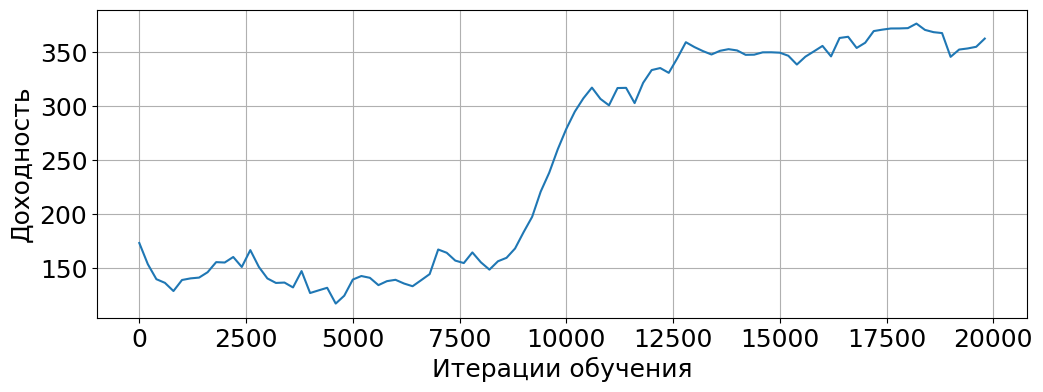

In [45]:
plt.figure(figsize=(12,4))
steps = range(0, number_iterations, eval_interval)
plt.plot(steps, data_result[0])
plt.grid(True)
plt.ylabel('Доходность')
plt.xlabel('Итерации обучения')

Text(0.5, 0, 'Итерации обучения')

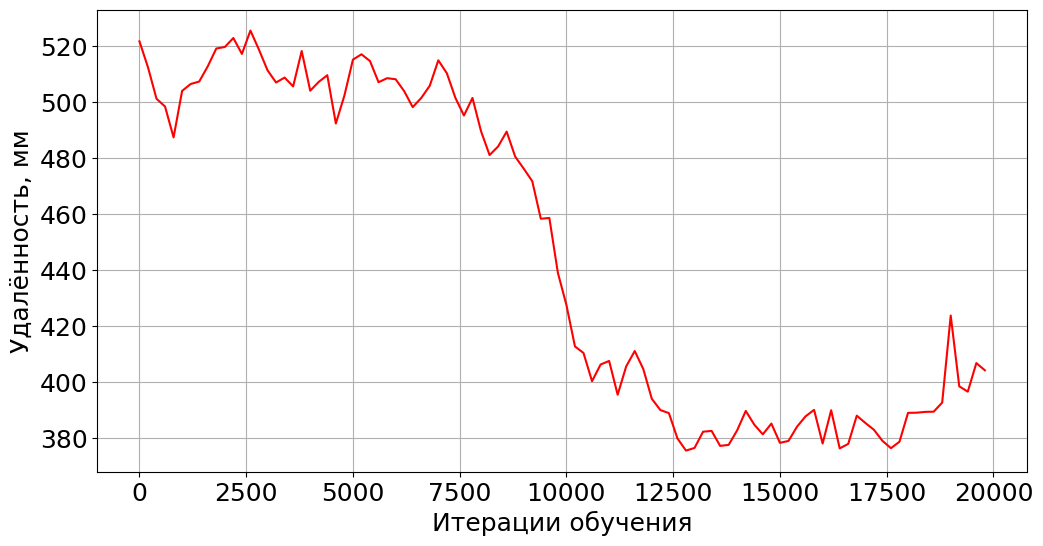

In [46]:
plt.figure(figsize=(12,6))
steps = range(0, number_iterations, eval_interval)
plt.plot(steps, data_result[1],'r')
plt.grid(True)
plt.ylabel('Удалённость, мм')
plt.xlabel('Итерации обучения')


Text(0.5, 0, 'Щаг')

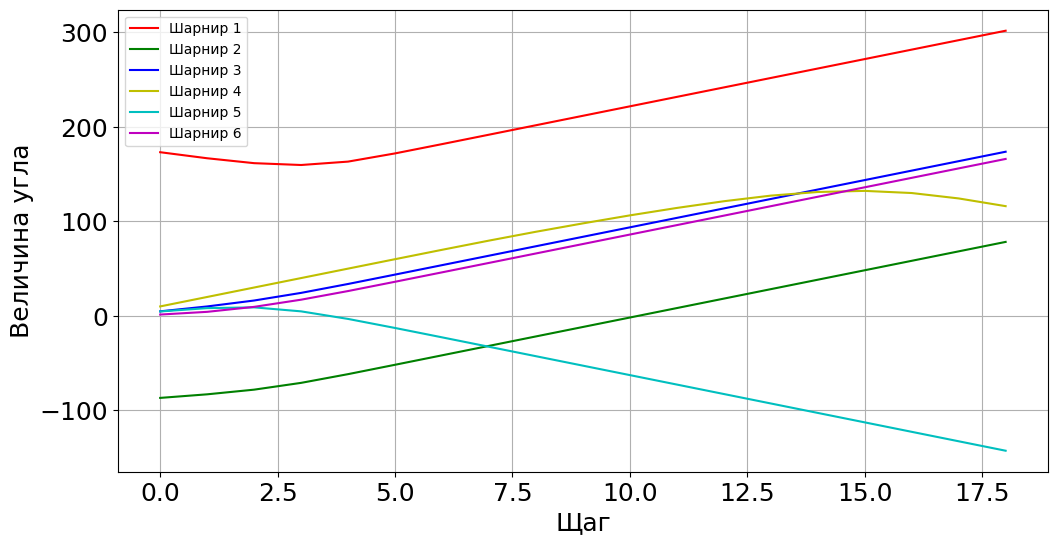

In [47]:
colors = ('r','g','b','y','c','m','k')
plt.figure(figsize=(12,6))
steps = range(0,  len(data_result[4][-1]))
joint_1=[]
joint_2=[]
joint_3=[]
joint_4=[]
joint_5=[]
joint_6=[]
for angles in data_result[4][-1]:
    joint_1.append(angles[0])
    joint_2.append(angles[1])
    joint_3.append(angles[2])
    joint_4.append(angles[3])
    joint_5.append(angles[4])
    joint_6.append(angles[5])
plt.plot(steps, joint_1, color='r', label='Шарнир 1')
plt.plot(steps, joint_2, color='g', label='Шарнир 2')
plt.plot(steps, joint_3, color='b', label='Шарнир 3')
plt.plot(steps, joint_4, color='y', label='Шарнир 4')
plt.plot(steps, joint_5, color='c', label='Шарнир 5')
plt.plot(steps, joint_6, color='m', label='Шарнир 6')
plt.legend()
plt.grid(True)
plt.ylabel('Величина угла')
plt.xlabel('Щаг')

100 20


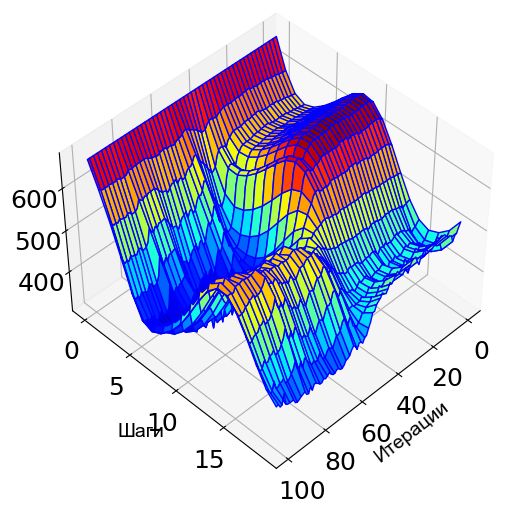

In [48]:
iteration = range(0, number_iterations + 1, eval_interval)
steps = steps = range(0,  len(data_result[2])+1)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection='3d')
a ={'fontname':'Arial', 'size':'14'}
plt.xlabel("Итерации",**a)
plt.ylabel ("Шаги",**a)

X=np.arange(len(data_result[2]))
Y=np.arange(len(data_result[2][0]))
X, Y = np.meshgrid(X, Y)
Z=np.array(data_result[2])
print(Z.shape[0],Z.shape[1])
Z=np.transpose(Z)
ax.plot_surface(X, Y, Z, cmap ='jet', edgecolor ='blue',alpha = 1)
ax.view_init(45,45)


100 20


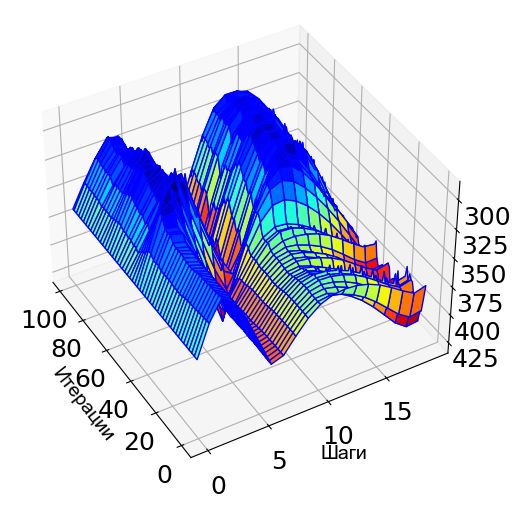

In [49]:
iteration = range(0, number_iterations + 1, eval_interval)
steps = steps = range(0,  len(data_result[3])+1)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection='3d')
a ={'fontname':'Arial', 'size':'14'}
plt.xlabel("Итерации",**a)
plt.ylabel ("Шаги",**a)

X=np.arange(len(data_result[3]))
Y=np.arange(len(data_result[3][0]))
X, Y = np.meshgrid(X, Y)
Z=np.array(data_result[3])
print(Z.shape[0],Z.shape[1])
Z=np.transpose(Z)
ax.plot_surface(X, Y, Z, cmap ='jet', edgecolor ='blue',alpha = 1)
ax.view_init(-140, 30)

In [50]:
from matplotlib import animation
def compute_animation_frames(environment, policy, size_episodes=1):
    frame = []
    for _ in range(size_episodes):
        time_step = environment.reset()
        reward = []
        action = []
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            img = environment.render()
            frame.append(img)
            reward.append(time_step.reward)
            action.append(action_step)
    return frame, time_step

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=100):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

C:\Users\Антон\AppData\Local\Temp\ipykernel_10736\1404663428.py:88: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  j_orient =orientation.as_euler('ZXZ',degrees=True)


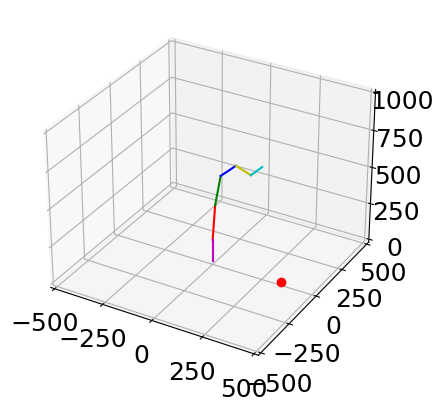

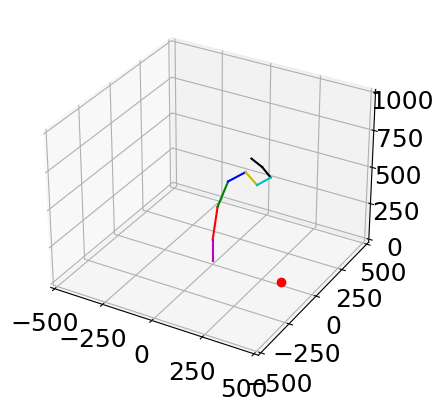

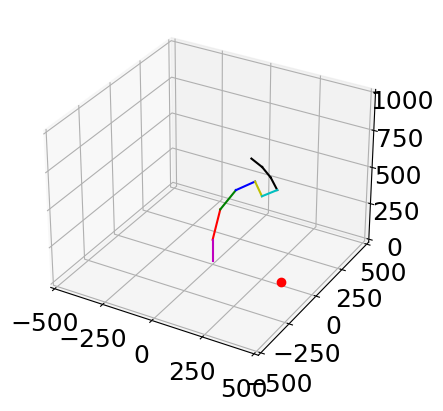

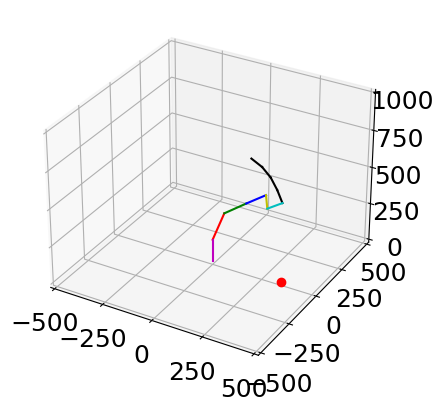

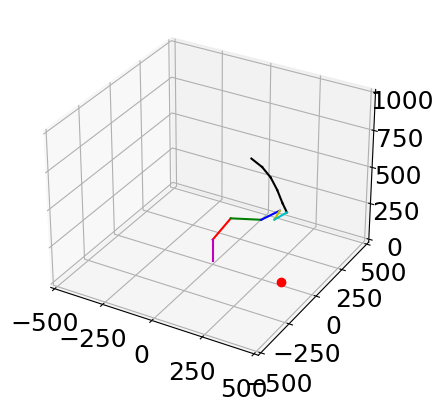

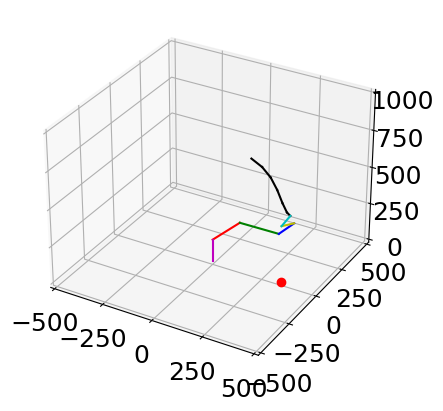

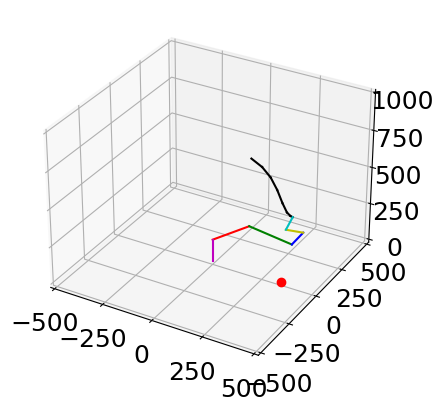

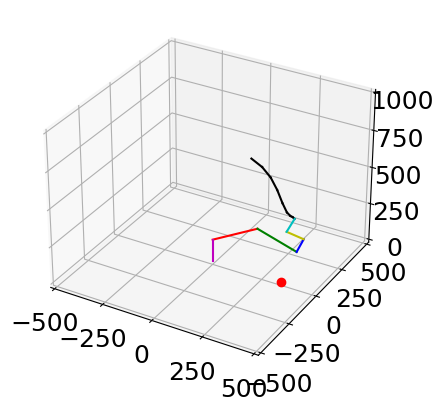

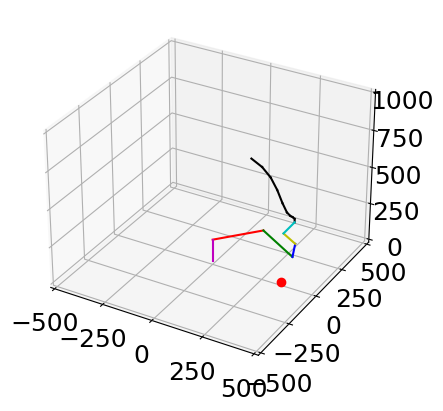

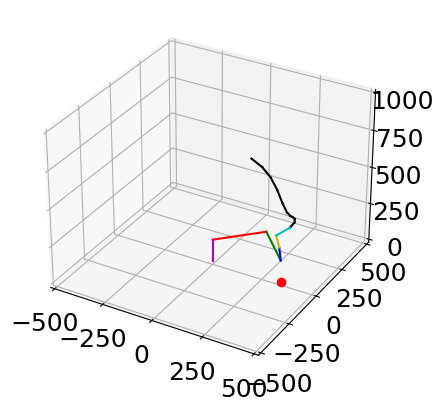

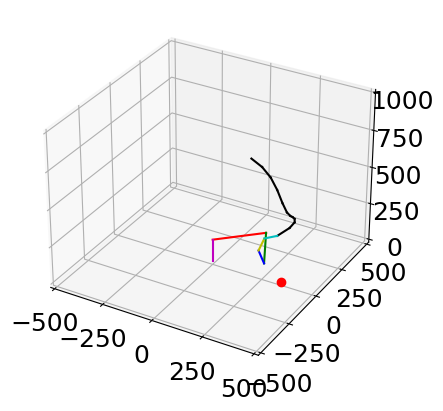

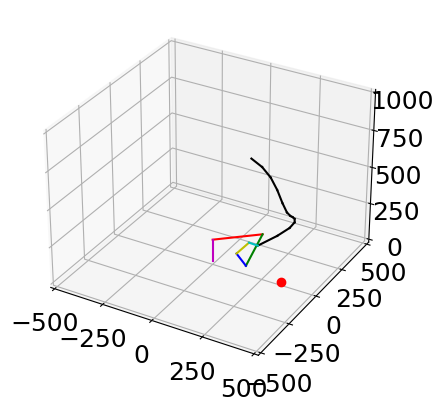

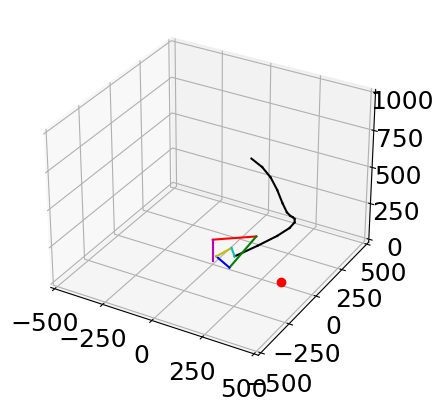

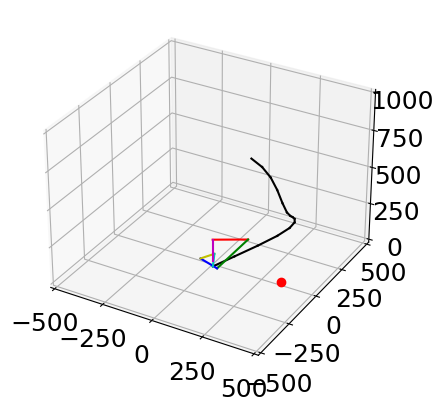

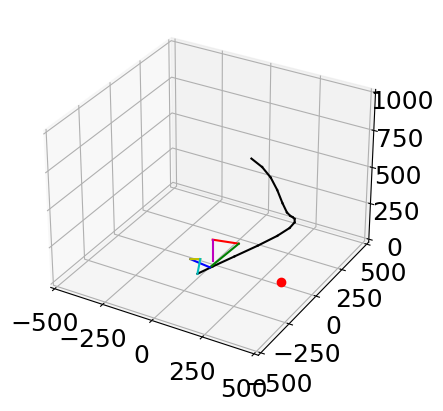

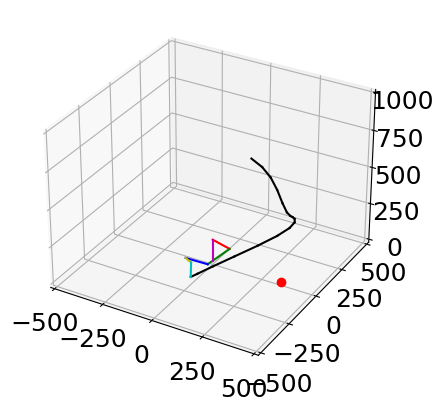

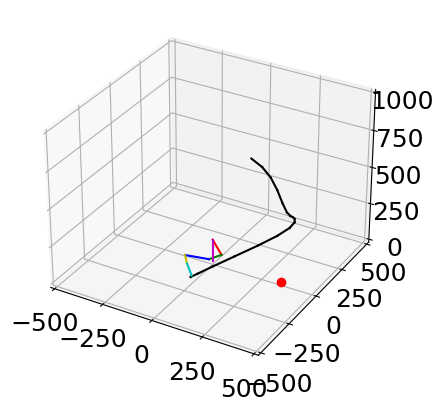

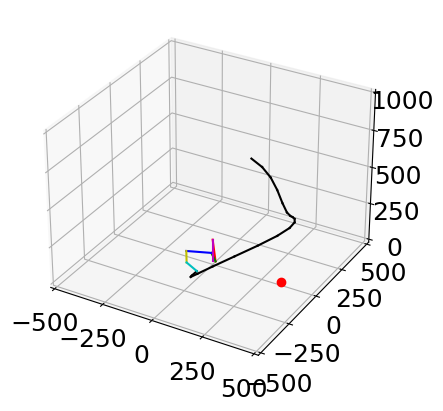

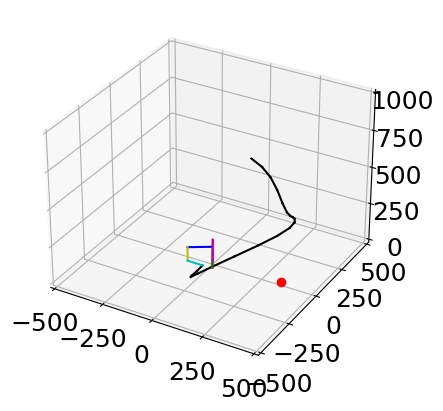

In [51]:
frames,last_obs = compute_animation_frames(train_env_py,tf_agent.policy)

In [52]:
plot_animation(frames)